Author: Chris Suberlak (@suberlak)

Software Versions:

* ts_wep: **v6.0.2**
* lsst_distrib: **w_2023_14**

# Introduction

Sensitivity Matrix is a way of quantifying the relationship between measured wavefront curvature (Zernike coefficients), and the required mechanical correction (mm of hexapod motion). As described in https://tstn-016.lsst.io/ , for auxiliary telescope (auxTel) it concerns the motion of the M2 mirror hexapod in one of three directions: x,y,z. `ts_wep` quantifies the wavefront using the annular Noll Zernike coefficients terms 4-22, called 4 (defocus), 5-6 (primary astigmatism),  7-8 (primary coma), 9-10 (trefoil), 11 (primary spherical), 12-13 (secondary astigmatism), 14-15 (quadrafoil), 16-17 (secondary coma), 18-19 (secondary trefoil), 20-21 (pentafoil), as seen on https://telescope-optics.dish-cable.com/images/zernike_noll.PNG . For auxTel sensitivity matrix, we only use the defocus (`Zk4`), and primary coma (`Zk7`,`Zk8`), as related to `dx`,`dy`,`dz` hexapod motion (with `dz` affecting primarily defocus term `Zk4`,  `dx` the coma-x `Zk7`,  and dy the coma-y `Zk8`). 


$\begin{bmatrix}
   dx \\
   dy \\
   dz
   \end{bmatrix}
   =
   \begin{bmatrix}
   C_{X}        & C_{YX} C_{Y} & C_{ZX} D_{Z} \\
   C_{XY} C_{X} & C_{Y}        & C_{ZY} D_{Z} \\
   C_{XZ} C_{X} & C_{YZ} C_{Y} &   D_{Z}
   \end{bmatrix}
   \times
   \begin{bmatrix}
   Z7 & Z8 & Z4
   \end{bmatrix}$

Due to tilts in the system, some of the cross-terms are non-zero (eg. $C_{ZY}$ measuring the impact of `dy` motion on `Z4` ).


# Setup

* access to USDF devl nodes
* working installation of ts_wep package ( see the following [notes](https://confluence.lsstcorp.org/display/LTS/Onboarding+to+LSST+AOS) on how to install and build the AOS packages)

# Imports



In [2]:
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline
import os

import subprocess
from lsst.daf.butler import Butler

from lsst.daf.butler import Butler
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

from galsim.zernike import zernikeRotMatrix

from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 


## Find CWFS pairs 

The [observing run on 2023-03-10](https://confluence.lsstcorp.org/display/LSSTCOM/2023-03-10+AuxTel+Night+Log) included multiple tests, as described in https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/notebooks/auxtel/observing_runs/20230310/analyzeWepOutput.ipynb .
    In this tech note we only use the subset of [sequence numbers](https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-03-10)  pertaining to [sensitivity matrix calculation](https://jira.lsstcorp.org/browse/SITCOM-718) (courtesy Bryce Kalmbach):
        
        
| Test | Observation Reason Prefix | Sequence Numbers | 
| :--: | :--: | :--: |
| Sensitivity Matrix Field 1, x/y offsets | intra/extra_aos_sm_offset | 33-52 
| Sensitivity Matrix Field 1, rx/ry offsets | intra/extra_aos_pointing_offset | 53-67 
| Sensitivity Matrix Field 2, x/y, rx/ry, z, m1 offsets | intra/extra_aos_sm_offset | 71-211 

In [3]:
input_collections = ['LATISS/raw/all', 'LATISS/calib/unbounded', 'LATISS/runs/quickLook']

butler = Butler(
    "/repo/embargo",
    collections=input_collections,
    instrument='LATISS'
)


records = list(
    butler.registry.queryDimensionRecords(
        "exposure",
        where="exposure.observation_type='cwfs' and exposure.day_obs=20230310"
    )
)
records.sort(key=lambda record: (record.day_obs, record.seq_num))

# Loop through and make pairs where 1st exposure is intra and second exposure is extra and have same group_id
# Save record information for each pair and sequence numbers for easy location later.
pairs = []
seq_nums = []
for record0, record1 in zip(records[:-1], records[1:]):
    if (
        record0.observation_reason.startswith('intra') and
        record1.observation_reason.startswith('extra') and
        record0.group_id == record1.group_id and
        not record0.physical_filter.startswith("empty")
    ):
        pairs.append((record0, record1))
        seq_nums.append(record0.seq_num)
seq_nums = np.array(seq_nums)

exp_nums = [int(f'20230310{seq_num+1:05d}') for seq_num in seq_nums]

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/s/scichris/.lsst/aws-credentials.ini


## Run AOS pipeline

For completeness, the cell below runs the complete pipeline  that does the instrument signature removal with `isr` task , donut detection with `generateDonutDirectDetectTask`, cutting out of donut stamps with `cutOutDonutsScienceSensorTask`, wavefront estimation with `calcZernikesTask`, is contained in the `latissWepPipeline.yaml` file (it is similar to https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/notebooks/auxtel/observing_runs/20230310/latissWepPipeline.yaml except for the image transpose which was found to be necessary). It can also be run via bps, as included in `run_bps_wep_submit.py`. 



In [ ]:
repo_dir = '/sdf/data/rubin/repo/embargo/'
output_collection = 'u/scichris/latiss_230310_run/wep_full'
butlerRW = SimplePipelineExecutor.prep_butler(repo_dir, 
                                              inputs=input_collections, 
                                              output=output_collection)
path_to_pipeline_yaml = os.path.join(os.getcwd(), 'latissWepPipeline.yaml' ) 
                                     
                                     
# Load pipeline from file
pipeline = Pipeline.from_uri(path_to_pipeline_yaml)

data_query = f"exposure in {tuple(exp_nums)}"
executor = SimplePipelineExecutor.from_pipeline(pipeline, where=data_query, butler=butlerRW)
quanta = executor.run(True)

# Inspect the results

The wavefront was measured with different rotation angle of the rotator and elevation, and need to be derotated. In general, "Zernikes either don’t change under rotation at all (such as the defocus term Z4), or they rotate in pairs (e.g., Z7 & Z8).  For the pairs, the rotation matrix is [[cos(m*a), -sin(m*a)], [sin(m*a), cos(m*a)]], where a is the angle in the coordinate system rotation and m is the azimuthal order of the particular Zernike pair.  For coma, m=1 so that the rotation matrix has sin(a) and cos(a).  For astigmatism, though, for example, m=2 so you’ll get sin(2a) and cos(2a).  The GalSim function  works all this out and formats things into a single block-diagonal matrix." (from Josh). 


The Noll Zernike expansion terms include x,y components of various moments (astigmatism, coma, trefoil). The total moment is conserved under rotation, and is plotted first as a sanity check, since these quantities do not change under rotation. 

First we plot these total moments -  invariant under rotation: total astigmatism (zk5,6), primary coma 
    (zk7,8), trefoil (zk9,10), etc. 

In [7]:
%matplotlib inline
from galsim.zernike import zernikeRotMatrix

from astropy.table import Table
d = Table.read('20230310_EFD_angle_data.txt', format='ascii')
d['angle'] = d['rot'] - d['el']

def plot_derot_total(axis = 'x'):
    if axis == 'x':
        dxs = np.linspace(-2, 2, 10)  
        intra_seq_nums = np.arange(71, 90, 2)
    
    elif axis == 'y':
        dxs = np.linspace(-2, 2, 10) # this is dy 
        intra_seq_nums = np.arange(91, 110, 2)
        
    elif axis == 'z':  
        dxs = np.linspace(-0.1, 0.1, 10) # this is dz 
        intra_seq_nums = np.arange(172, 191, 2)
        
    zernikes = []
    for seq_num in intra_seq_nums:
        zernikes.append(
            butler.get(
                "zernikeEstimateAvg", 
                dataId={'instrument':'LATISS', 'detector':0, 'visit':int(f'20230310{seq_num+1:05d}')}
            )
        )
    zernikes = np.array(zernikes)  # this is unrotated 4:22 

    # pad with 4 zeros so that array[N]  corresponds to ZkN
    zk1_22_list = []
    for zk4_22 in zernikes:
        zk1_22 = np.pad(zk4_22,[4,0])
        zk1_22_list.append(zk1_22)
    zk1_22_arr = np.array(zk1_22_list)


    zk1_22_rot_list = []
    for pair in range(len(intra_seq_nums)):

        zk1_22_unrot = zk1_22_arr[pair]

        seq_num = intra_seq_nums[pair]
        intra_name = 'AT_O_20230310_'+   str(seq_num).zfill(6)

        # derotate by applying matrix multiplication
        # I think that `angle` already  incorporates the camera rotation angle ... 
        angle =  d[d['intra'] == intra_name]['angle'].value[0]
        #print('\n', angle)

        #print(zk1_22_unrot)

        #camera_rotation_angle = 0 
        # I think it's already incorporated in `angle` 
        # thus I don't include it below 
        zk1_22rot = np.matmul(zk1_22_unrot, zernikeRotMatrix(22, -np.deg2rad(angle)))
        #print(zk1_22rot)
        zk1_22_rot_list.append(zk1_22rot)

    zk1_22_rot_arr = np.array(zk1_22_rot_list)

    titles = {5:'astigmatism', 7:'coma', 9:'trefoil', 
                  12:'2nd astigmatism',14:'quadrafoil',16:'2nd coma',
                  18:'2nd trefoil',20:'pentafoil'}

    # rename rotated 4:22 to use the same plotting code 
    #zernikes = zk1_22_rot_arr[:,4:]
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,6))
    axes = axes.ravel()
    xdata = dxs

        
    i = 0 
    for j in titles.keys():

        #zk_x = zernikes[:,j-4]  # eg. zk5
        #zk_y = zernikes[:,j-3]  # eg. zk6 
        #print(j)
        
        # plot the rotated Zks 
        zk_x = zk1_22_rot_arr[:,j]  # eg. zk5
        zk_y = zk1_22_rot_arr[:,j+1]  # eg, zk6 
        ydata = np.sqrt(zk_x**2. + zk_y**2.)
        axes[i].scatter(xdata, ydata, marker='d',s=95, label='original')
        
        # plot the unrotated Zks 
        zk_x = zk1_22_arr[:,j]
        zk_y = zk1_22_arr[:,j+1]
        ydata = np.sqrt(zk_x**2. + zk_y**2.)
        axes[i].scatter(xdata, ydata, marker='s', label='rotated')
        
        axes[i].set_title(f"Z{j,j+1}: {titles[j]}")

        i += 1

    for ax in axes:
        ax.set_ylim(0., 0.36)
        ax.axhline(0, c='k')
    fig.text(0.44,0, f"M2 d{axis} [mm]", fontsize=14)
    fig.text(-0.02
             ,0.4,"WFE [µm]", rotation='vertical',fontsize=14 )
    #axes[0].set_ylabel("WFE [µm]")
    #axes[4].set_ylabel("WFE [µm]")
    #ax.set_xlabel()
    plt.tight_layout()
    plt.show()


In [5]:
output_collection = 'u/scichris/latiss_230310_run/wep_with_transpose_'
butler = Butler(
    "/sdf/data/rubin/repo/embargo/",
    collections=[output_collection],
    instrument='LATISS'
)

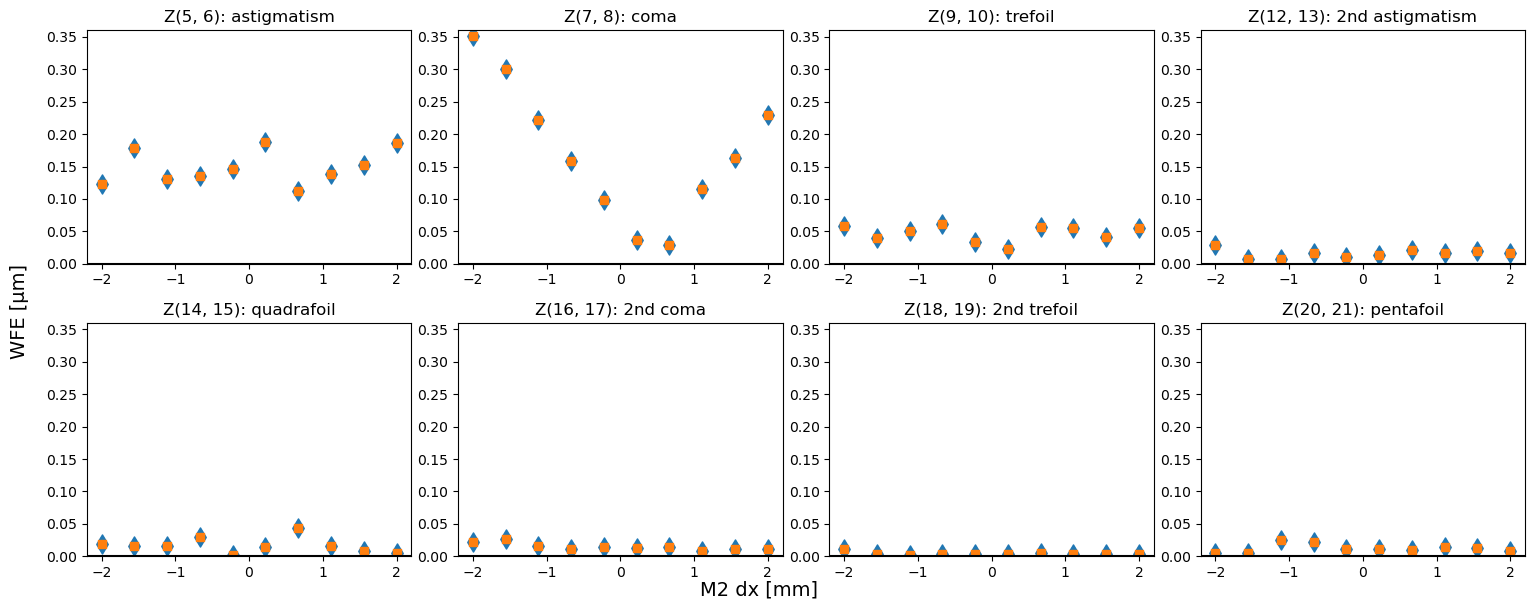

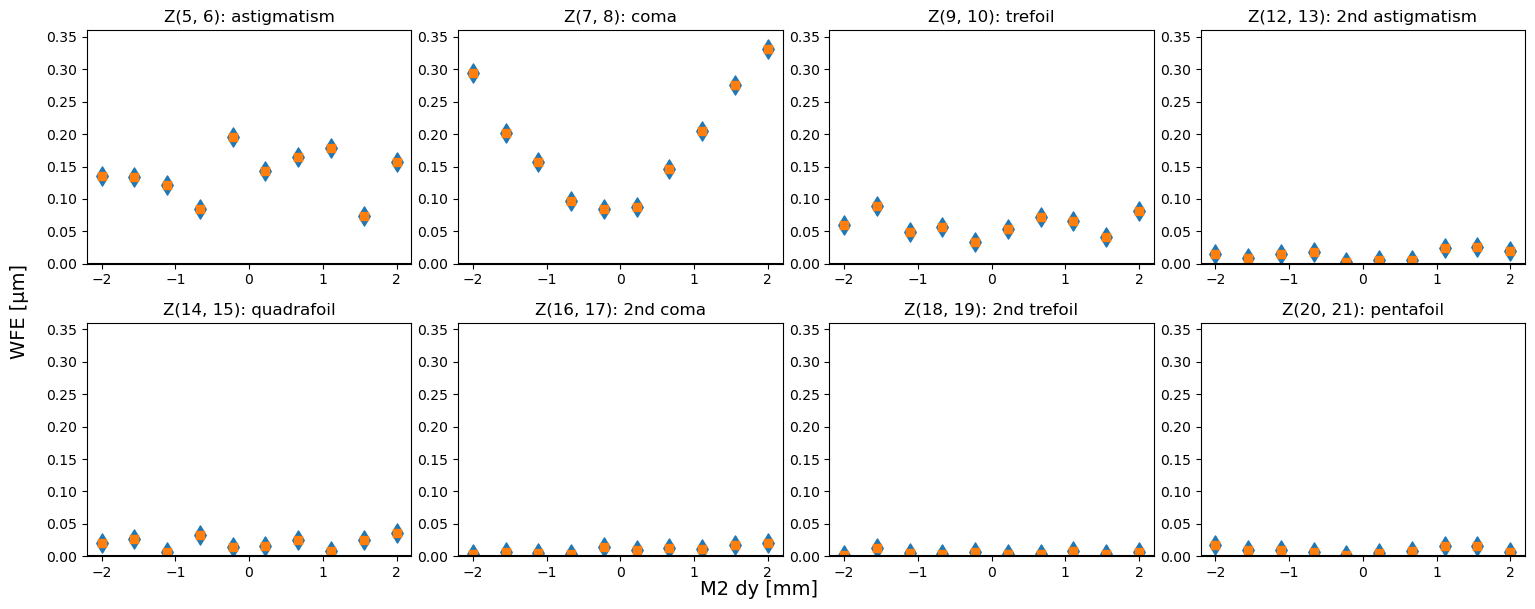

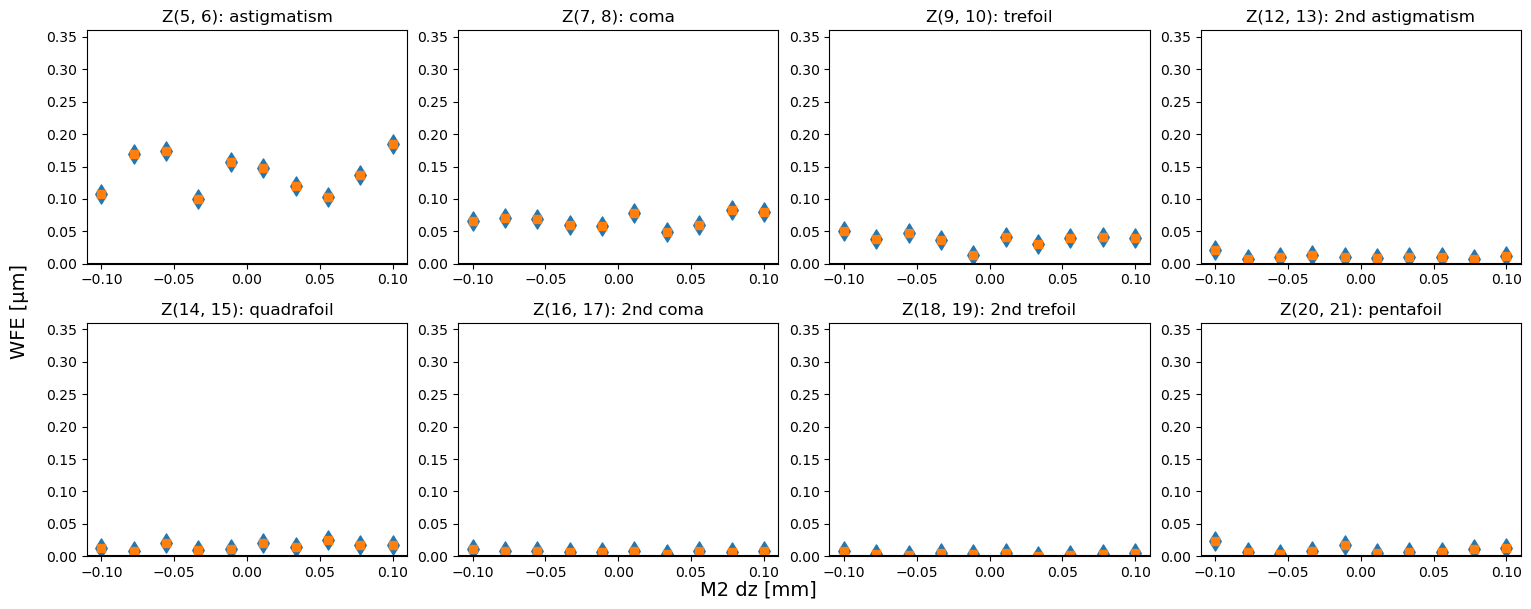

In [8]:
for axis in 'xyz':
    plot_derot_total(axis = axis)

Blue diamonds are original (rotated), and  orange squares are derotated Zernike values. 